# Guia para hacer un modelo de ia del examen


## Ejercicio 1: Limpiar los datos



QUITANDO FILAS Y COLUMNAS Y NORMALIZANDO DATOS

Para normalizar los datos hay que tener en cuenta que:
    
* Discretos/Enumerados/Cualitativos -> OneHotEncoding o Labled Encoder
        OneHotEncoding -> por defecto, si dudas usa este
        LabledEncoder -> si los valores tienen un orden

* Continuos -> StandardScaling, para normalizarlos y llevarlos a una escala comun



        solo deberia hacer falta copiar este codigo y cambiar las columnas en ATRIBUTOS, en final_data salen todos los datos sin el atributo solucion y en labeled_data el solucion

In [ ]:
import glob as glob
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset
data = pd.read_csv('dementia_dataset.csv')



# ---------------- / GESTIÓN DE NULOS / ------------------- 
# ----- DIAGNOSTICO
# print("--- INFO ---")
# print(data.info())
# print("\n--- NULOS POR COLUMNA ---")
# print(data.isnull().sum()) # ¡ESTO ES CRUCIAL!
# Si ves una columna con 50% de nulos -> A la lista 'unnecessary_columns'
# Si ves una columna con 5% de nulos -> Imputar (media) o Borrar filas

# Cuantos datos perderiamos: 
    # Si se pierden 10-15 filas OPCION A
    # si se pierden 50-100 filas OPCION B

# ----- QUITAR / MODIFICAR NULOS
# OPCIÓN A : Borrar filas con huecos.
# Úsalo si tienes muchos datos (>1000) y pocos huecos.
# data = data.dropna(how="any")

# OPCIÓN B (Alternativa si tienes pocos datos): IMPUTAR
# Si ves que al hacer dropna te quedas con muy pocas filas, usa esto antes de escalar:
# data['SES'] = data['SES'].fillna(data['SES'].mean()) # Imputa la media en los huecos de SES (ejemplo numérico)
# SES: Es un valor socioeconómico (float). Usamos la mediana porque es más robusta.
#data['SES'] = data['SES'].fillna(data['SES'].median())
# MMSE: Es un test mental. Usamos la media (o mediana, ambas valen).
#data['MMSE'] = data['MMSE'].fillna(data['MMSE'].mean())
# Verificamos que ya no quedan nulos
#print("Nulos restantes:", data.isnull().sum().sum())




# --------------- / ATRIBUTOS / ---------------------
unnecessary_columns = []
oneHot_columns = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope", "FastingBS"] # VALORES CATEGÓRICOS A OHE, o 0/1
standardScaling_columns = ["Age", "RestingBP","Cholesterol", "MaxHR", "Oldpeak"] # VALORES NUMERICOS A ESCALAR, menos los que sean 0 y 1
labeled_columns = ["HeartDisease"] # SOLUCION

solucion = "HeartDisease" # Nombre de la columna solución



# ---------------- / DROP /  -------------------
# Borramos lo que no sirve para limpiar el ruido del dataset.
final_data = data.drop(columns=unnecessary_columns) 



# ---------------- / OHE /  -------------------
encoder = OneHotEncoder(sparse_output=False) 
encoder_final = encoder.fit_transform(data[oneHot_columns])  
# Creamos un DF temporal con nombres bonitos (ej: "M/F_M", "M/F_F")
oneHot_df = pd.DataFrame(
    encoder_final, 
    columns=encoder.get_feature_names_out(oneHot_columns), 
    index=data.index  # <--- ¡ESTO ES LO QUE FALTABA!
)


# ---------------- / SCALER /  -------------------
# Transforma los datos para que tengan media 0 y desviación típica 1 (Curva de Gauss).
scaler = StandardScaler()
scaler_final = scaler.fit_transform(data[standardScaling_columns])
df_sc = pd.DataFrame(scaler_final, columns=standardScaling_columns, index=data.index)



# ----------------- / LABELED ENCODER / -------------------------   
# Convierte "Demented" -> 0, "Nondemented" -> 1, etc.
labler = LabelEncoder()
labeled_final = labler.fit_transform(data[labeled_columns].values.ravel()) # o labeled_final = labler.fit_transform(data[labeled_columns])
df_lbl = pd.DataFrame(labeled_final, columns=labeled_columns, index=data.index)
# ----------------------------------------------------------------------

# ---------------- / CONCATENAR (SOLUCION AL FINAL) / -------------------
# ---- 1. Juntamos las 3 partes: Numéricos Escalados + Categóricos OHE + Solución Codificada
final_data = pd.concat([df_sc, oneHot_df, df_lbl], axis=1) #axis=1 significa "pegar columnas a la derecha"


# print("\nColumnas finales:")
# print(final_data.columns.tolist()) # Verifica que NO hay "algo_nan", si lo hay es que no se han gestionado bien los nulos.

# final_data.head()

# ---------------- / OPCIONAL / -------------------
# # Opcional: prints para verificar
# print("Tamaño final del dataset:", final_data.shape)
# # para guardarlas en un archivo (opcional)
# final_data.to_csv("./examen_limpio.csv", index=False)


c:\Anaconda\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Slices

La sintaxis de slicing ([:]) es la herramienta número 1 para trocear tus datos. Casi siempre tendrás un CSV donde la última columna es la solución (ej: HeartDisease o Group). Usando pandas: 
* dataset.iloc[:, :-1] $\to$ Coge TODAS las filas (:) y TODAS las columnas MENOS la última (:-1). $\to$ Esto es tu X.dataset.
* iloc[:, -1] $\to$ Coge TODAS las filas (:) y SOLO la última columna (-1). $\to$ Esto es tu y.

#### Ejemplo práctico de examen
1. Separar features y target
* X = final_data.iloc[:, :-1]  # Todo menos la solución
* y = final_data.iloc[:, -1]   # Solo la solución

2. Dividir datos manualmente (Train / Test)
Si no te dejan usar train_test_split de sklearn (raro, pero posible) o si son series temporales (donde no puedes mezclar aleatoriamente):
* datos[:800] $\to$ Coge desde el principio hasta la fila 800 (Entrenamiento).
* datos[800:] $\to$ Coge desde la fila 800 hasta el final (Test).

3. Imágenes (CNNs)
Si te cae algo de imágenes (matrices 3D: Alto, Ancho, Canales):
* imagen[:, ::-1] $\to$ Invierte la imagen horizontalmente (Efecto espejo para Data Augmentation).
* imagen[10:100, 10:100] $\to$ Recorta la imagen (Crop) para quitar bordes inútiles.

In [1]:
a = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
start = 0
stop = 2
step = 1

a[start:stop]  # items start through stop-1
a[start:]      # items start through the rest of the array
a[:stop]       # items from the beginning through stop-1
a[:]           # a copy of the whole array

# ---------------------------------------------

a[start:stop:step] # start through not past stop, by step

# ---------------------------------------------

a[-1]    # last item in the array
a[-2:]   # last two items in the array
a[:-2]   # everything except the last two items

# ---------------------------------------------

a[::-1]    # all items in the array, reversed
a[1::-1]   # the first two items, reversed
a[:-3:-1]  # the last two items, reversed
a[-3::-1]  # everything except the last two items, reversed


[7, 6, 5, 4, 3, 2, 1, 0]

## Ejercicio 2: Representar los datos


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA


# -------------------- / PREPARACIÓN / -------------------
# Usamos nombres distintos (_vis) para no machacar las variables del modelo (X, y)
X_vis = final_data.drop(columns=[solucion])      # Datos para el PCA
y_vis = df_lbl.values.ravel() # Etiquetas para colorear (flattened)

# puede que antes de PCA sea necesario usar los datos listos para el MODELO (SIGUIENTE CELDA):
# X_vis = final_data.drop(columns=[solucion]) # Datos sin la columna solución
# y_vis = y


# clase: TIENE QUE SER UN STRING, NO UNA LISTA
clase = "Group"        # variable solucion


# ---------------- / DISTRIBUCIÓN DE CLASES / -------------------
# Úsalo si piden "Ver distribución de clases" o "Balanceo del dataset"
print(f"--- Distribución de {clase} ---")
plt.figure(figsize=(6, 4))

# TRUCO PRO: Usamos 'data' (el original) en vez de 'labeled_data' para que
# en el gráfico salgan los nombres ("Demented") en vez de números (0, 1).
# Si usas 'labeled_data' saldrán 0, 1, 2.
                                      
data[clase].value_counts().plot(kind='bar', color=['skyblue', 'orange']) # pon mas colores si hace falta
plt.title(f"Distribución de la variable objetivo: {clase}")
plt.xlabel("Clases")
plt.ylabel("Cantidad de pacientes")
plt.xticks(rotation=0) # Para que las letras se lean rectas
plt.grid(axis='y', alpha=0.3)
plt.show()



# ------------------- / PCA (Reducción) / ------------------------ 
pca_comp = PCA(n_components=2)
# ¡OJO! X_vis tiene que ser SOLO NÚMEROS.
x_pca = pca_comp.fit_transform(X_vis)

# Cuanta info mantenemos:
print(f"Varianza explicada: {pca_comp.explained_variance_ratio_.sum():.2f}") 

df_pca = pd.DataFrame({
    "c1": x_pca[:, 0],    # Componente Principal 1
    "c2": x_pca[:, 1],    # Componente Principal 2
    clase: y_vis             # el color (0,1,2...)
})

grupos = sorted(df_pca[clase].unique()) # [0, 1, 2]



# ---------------------------- / PINTADO / ------------------------ 
# Colores: Usamos un mapa de colores automático
colormap = plt.get_cmap("viridis")
colors = colormap(np.linspace(0, 1, len(grupos)))

for i, g in enumerate(grupos):
    # Filtramos los puntos de ese grupo
    subset = df_pca[df_pca[clase] == g]
    
    # --- ETIQUETAS REALES (Demented vs 0) ---
    # Intentamos recuperar el nombre real usando el 'labler' del Ejercicio 1.
    try:
        nombre_real = labler.inverse_transform([g])[0]
    except:
        nombre_real = f"Clase {g}" # Si falla, ponemos Clase 0, Clase 1...
    
    plt.scatter(
        subset["c1"], 
        subset["c2"],
        color=colors[i],
        alpha=0.7,
        s=80,             # Tamaño del punto
        label=nombre_real # ¡Importante para la leyenda!
    )

plt.legend(title="Estado del Paciente")
plt.title("PCA: Visualización de datos tras limpieza")
plt.xlabel(f"Componente 1 ({pca_comp.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"Componente 2 ({pca_comp.explained_variance_ratio_[1]*100:.1f}% var)")
plt.grid(True, alpha=0.3)
plt.show()

NameError: name 'final_data' is not defined

## PREPARACION EJERCICIOS 3 en adelante
HAY QUE SEPARAR la columna solucion de los datos.

In [ ]:
# ---------------- / SEPARAR X (DATOS) e Y (SOLUCIÓN) / -------------------
# PASO A: Sacamos la Y (Solo la columna solución)
# .values.ravel() convierte la columna en un array plano [0, 1, 2, ...]
y = final_data[solucion].values.ravel() 

# PASO B: Sacamos la X (Datos MENOS la solución)
X = final_data.drop(columns=[solucion])     # Pandas DataFrame (para ver nombres columnas si quieres)
X_numpy = X.values                          # Numpy Array (para los modelos)

# VERIFICACIÓN (Míralo en el examen)
# VERIFICACIÓN (Míralo en el examen)
print(f"Shape de X (Datos): {X_numpy.shape}") # Ejemplo: (373, 12)
print(f"Shape de y (Target): {y.shape}")       # Ejemplo: (373,)
X.head()



## Ejercicio 3: MLP

In [ ]:
# ==============================================================================
# EJERCICIO 3: ENTRENAMIENTO Y EVALUACIÓN DEL MLP
# ==============================================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ---------------------------------------------------------
# 1. COPIA AQUÍ TU CLASE 'MultilayerPerceptron' ENTERA
# ---------------------------------------------------------

class MultilayerPerceptron:
    def __init__(self, layers, learning_rate=0.1, epochs=5000):
        self.layers = layers
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = []
        self.biases = []
        self.loss_history = []
        
        np.random.seed(42) 
        for i in range(len(layers) - 1):
            limit = np.sqrt(6 / (layers[i] + layers[i+1]))
            w = np.random.uniform(-limit, limit, (layers[i], layers[i+1]))
            b = np.zeros((1, layers[i+1]))
            self.weights.append(w)
            self.biases.append(b)

    def sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, a):
        return a * (1 - a)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True)) 
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def forward(self, X):
        activations = [X]
        input_data = X
        for i in range(len(self.weights) - 1):
            z = np.dot(input_data, self.weights[i]) + self.biases[i]
            a = self.sigmoid(z) 
            activations.append(a)
            input_data = a
        z_last = np.dot(input_data, self.weights[-1]) + self.biases[-1]
        activations.append(self.softmax(z_last))
        return activations

    def backpropagation(self, X, y_onehot, activations):
        m = X.shape[0]
        deltas = [activations[-1] - y_onehot]
        for i in range(len(self.weights) - 2, -1, -1):
            delta_prev = np.dot(deltas[-1], self.weights[i+1].T) * self.sigmoid_derivative(activations[i+1])
            deltas.append(delta_prev)
        deltas.reverse()
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * (np.dot(activations[i].T, deltas[i]) / m)
            self.biases[i] -= self.learning_rate * (np.sum(deltas[i], axis=0, keepdims=True) / m)

    def fit(self, X, y):
        y = y.astype(int) 
        y_onehot = np.eye(len(np.unique(y)))[y]
        print(f"Entrenando MLP Propio: {self.layers}")
        for epoch in range(self.epochs):
            activations = self.forward(X)
            self.backpropagation(X, y_onehot, activations)
            if epoch % (self.epochs // 10) == 0:
                loss = -np.mean(np.sum(y_onehot * np.log(activations[-1] + 1e-8), axis=1))
                self.loss_history.append(loss)
                print(f"   Epoch {epoch}: Loss {loss:.4f}")

    def predict(self, X):
        return np.argmax(self.forward(X)[-1], axis=1)


In [ ]:

# División Train / Test (80% - 20%)
# stratify=y_numpy es OBLIGATORIO en exámenes para que las clases estén balanceadas en el test
X_train, X_test, y_train, y_test = train_test_split(
    X_numpy, y_numpy, test_size=0.2, random_state=42, stratify=y_numpy
)

# ---------------------------------------------------------
# CONFIGURACIÓN DE LA RED
# ---------------------------------------------------------
input_dim = X_train.shape[1]         # Número de neuronas de entrada (automático)
output_dim = len(np.unique(y_numpy)) # Número de clases/salidas (automático)

# EL ENUNCIADO PIDE: "Prueba con más de una capa oculta".
# Estructura: [Entrada, Oculta1, Oculta2, ..., Salida]
# Recomendación examen: Empieza con algo potente como [input, 64, 32, output]
layer_structure = [input_dim, 64, 32, output_dim] 

# ---------------------------------------------------------
# INSTANCIAR Y ENTRENAR
# ---------------------------------------------------------
print(f"--- Entrenando Modelo con estructura: {layer_structure} ---")

# CONSEJOS HIPERPARÁMETROS SI EL ACCURACY ES BAJO:
# 1. learning_rate: Prueba 0.1, 0.01, 0.001. Si es muy alto oscila, si es muy bajo no aprende.
# 2. epochs: Sube a 10000 o 20000 si la curva de loss sigue bajando.
mi_mlp = MultilayerPerceptron(layers=layer_structure, learning_rate=0.1, epochs=10000)

mi_mlp.fit(X_train, y_train)

# ---------------------------------------------------------
# EVALUACIÓN Y RESULTADOS
# ---------------------------------------------------------
# Predicción
y_pred = mi_mlp.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"\n>>> ACCURACY CONSEGUIDO: {acc*100:.2f}%")

if acc < 0.65:
    print("⚠️ ALERTA: No llegas al 65%. Sube epochs, baja learning_rate o añade neuronas.")
else:
    print("✅ OBJETIVO CUMPLIDO (>65%)")

#### Modelo definitivo:
El modelo seleccionado es una red con arquitectura [X, 64, 32, Y] con learning_rate=0.1 y 10000 epochs porque ha conseguido el mejor equilibrio entre convergencia y precisión en test (superando el 65%).

In [ ]:
# ---------------------------------------------------------
# GRÁFICAS (CURVA + MATRIZ DE CONFUSIÓN)
# ---------------------------------------------------------
plt.figure(figsize=(12, 5))

# Gráfica 1: Curva de Pérdida (Loss)
plt.subplot(1, 2, 1)
plt.plot(mi_mlp.loss_history)
plt.title("Curva de Aprendizaje (Loss)")
plt.xlabel("Iteraciones")
plt.ylabel("Error")
plt.grid(True, alpha=0.3)

# Gráfica 2: Matriz de Confusión (Bonita)
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Matriz de Confusión")
plt.xlabel("Predicción del Modelo")
plt.ylabel("Valor Real")

plt.tight_layout()
plt.show()

# (Opcional) Informe detallado por clase
print("\n--- INFORME DETALLADO ---")
# Si tienes el 'labler' del ejercicio 1, usa target_names para que salgan los nombres reales
try:
    nombres_clases = labler.classes_.astype(str)
    print(classification_report(y_test, y_pred, target_names=nombres_clases))
except:
    print(classification_report(y_test, y_pred))

## Ejercicio 4: Otros modelos

### MLP SKlearn

   | pros | cons | 
   |---|---|
   | tolerancia a ruido | Caja Negra: No sabes por qué decide lo que decide. |
   | Potencia: Capaz de aprender relaciones muy complejas y no lineales. (lineal y no lineal) | Datos: Necesita muchos datos para brillar (con 300 filas suele sufrir). |
   | Escalable: Mejora cuantos más datos le des. | Sensible: Requiere escalar datos (StandardScaler) y ajustar muchos hiperparámetros (learning rate, capas...). |

Úsala si piden replicar una red clásica o si te piden parámetros específicos.


In [3]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN (TOCA AQUÍ SI NO LLEGAS A LA NOTA) ---
# Si Accuracy bajo -> Sube capas (ej: (100, 50)) o sube ITERATIONS
# Si tarda mucho -> Sube LR_INIT (ej: 0.01)
LAYERS = (64, 32)
LR_INIT = 0.01   # Con SGD a veces hay que subirlo un poco
ITERATIONS = 5000

print("--- Entrenando MLP Sklearn (SGD)... ---")
mlp_sklearn = MLPClassifier(
    hidden_layer_sizes=LAYERS,
    activation='logistic',  # Sigmoide
    solver='sgd',           # Descenso de gradiente clásico
    max_iter=ITERATIONS,
    learning_rate_init=LR_INIT,
    random_state=42,
    verbose=False           # Pon True si quieres ver si avanza
)

mlp_sklearn.fit(X_train, y_train)
y_pred = mlp_sklearn.predict(X_test)

# --- RESULTADOS ---
acc = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy MLP (SGD): {acc*100:.2f}%")

# Matriz de Confusión
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - MLP SGD")
plt.show()

--- Entrenando MLP Sklearn (SGD)... ---


NameError: name 'X_train' is not defined

### MLP Sklearn "OPTIMIZADO" (Adam + ReLU)

si piden "Máximo rendimiento" o un accuracy muy alto (>85%). Es la más potente.

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN PRO ---
# ADAM + RELU convergen muchísimo más rápido y mejor.
LAYERS = (100, 50) 

print("--- Entrenando MLP Optimizado (Adam + ReLU)... ---")
mlp_opt = MLPClassifier(
    hidden_layer_sizes=LAYERS,
    activation='relu',      # ¡CLAVE! ReLU evita desvanecimiento de gradiente
    solver='adam',          # ¡CLAVE! Adam optimiza el learning rate solo
    max_iter=5000,
    alpha=0.0001,           # Regularización L2 (sube si hay overfitting)
    random_state=42,
    early_stopping=True     # Para si deja de mejorar (ahorra tiempo)
)

mlp_opt.fit(X_train, y_train)
y_pred = mlp_opt.predict(X_test)

# --- RESULTADOS ---
acc = accuracy_score(y_test, y_pred)
print(f"🚀 Accuracy MLP Optimizado: {acc*100:.2f}%")

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
plt.title("Matriz de Confusión - MLP Adam")
plt.show()

### KNN

   | pros | cons | 
   |---|---|
   | caja blanca. Simple: Muy fácil de entender. | Sensible: El ruido y los datos no escalados lo destrozan. |
   | entrenamiento rapido | ejecucion lenta |
   | tolerancia a la forma de los datos | costoso en memoria. Maldición de la dimensión: Funciona fatal si hay muchas columnas (atributos). |

Si tienes muchos datos es lento. Si tienes muchas dimensiones funciona regular.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN ---
# n_neighbors: Típico 3, 5, 7. MEJOR IMPARES - CAMBIAR ESTO SI NO LLEGAS 
# Si el número es muy bajo (1) -> Overfitting (ruido).
# Si es muy alto (20) -> Underfitting (demasiado suave).
K = 5

print(f"--- Entrenando KNN (k={K})... ---")
knn = KNeighborsClassifier(n_neighbors=K)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# --- RESULTADOS ---
acc = accuracy_score(y_test, y_pred)
print(f"📍 Accuracy KNN: {acc*100:.2f}%")

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Reds')
plt.title(f"Matriz de Confusión - KNN ({K})")
plt.show()

-> Validacion KNN: 82.02%


c:\Users\Ines\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


### Decision Tree


   | pros | cons | 
   |---|---|
   | caja blanca. Totalmente interpretable (sabes qué reglas usa). | Inestable: Si cambias un poquito los datos, el árbol cambia entero. (sensible al ruido) |
   | entrenamiento rapido | simple |
   | Feature Importance: Te dice qué variables importan. | Tendencia al Overfitting: Si no limitas la profundidad (max_depth), memoriza los datos.|
   | Pocos datos: Funciona bien con datasets pequeños. |  |

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN (TOCA AQUÍ) ---
# Si Accuracy bajo (Underfitting) -> SUBE max_depth (ej: 15, 20 o None)
# Si Overfitting (Train 100% pero Test bajo) -> BAJA max_depth (ej: 5, 8)
DEPTH = 10 

print(f"--- Entrenando Árbol de Decisión (Depth={DEPTH})... ---")
dt = DecisionTreeClassifier(max_depth=DEPTH, random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

# --- RESULTADOS ---
acc = accuracy_score(y_test, y_pred)
print(f"🌳 Accuracy Decision Tree: {acc*100:.2f}%")

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges')
plt.title("Matriz de Confusión - Decision Tree")
plt.show()

# Opcional: Ver importancia de variables
# print("Importancia:", dict(zip(final_data.columns[:-1], dt.feature_importances_)))

-> Validacion DT: 80.90%


### Random Forest

   | pros | cons | 
   |---|---|
   | El "Todoterreno": Casi siempre da el mejor Accuracy sin tocar nada. | Caja Gris/Negra: Pierdes la interpretabilidad sencilla de un solo árbol (son 100 árboles votando). |
   | Robusto: Evita el Overfitting mucho mejor que un Árbol simple. | Lento: Tarda más en entrenar que un árbol simple. |

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN ---
# n_estimators: Número de árboles (100 suele bastar, sube a 200 si necesitas más estabilidad)
# max_depth: Igual que en el árbol, controla la complejidad.
rf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)

print("--- Entrenando Random Forest... ---")
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# --- RESULTADOS ---
acc = accuracy_score(y_test, y_pred)
print(f"🌲🌲 Accuracy Random Forest: {acc*100:.2f}%")

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Purples')
plt.title("Matriz de Confusión - Random Forest")
plt.show()

-> Validacion RF: 89.89%


c:\Users\Ines\anaconda3\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


# Ejercicio 5.A: Comparativa y Elección del Modelo

 1. Tabla Resumen de Resultados

| Característica | **Modelo A (ej. MLP)** | **Modelo B (ej. Decision Tree)** |
| :--- | :--- | :--- |
| **Accuracy (Test)** | [ PONER DATO % ] | [ PONER DATO % ] |
| **Matriz de Confusión** | [ ¿Falla más en Falsos Positivos o Negativos? ] | [ ¿Está equilibrada? ] |
| **Tipo de Modelo** | Caja Negra (Opaco) | Caja Blanca (Interpretable) |
| **Entrenamiento** | Lento / Requiere muchos datos | Rápido / Eficiente con pocos datos |

 2. Elección del Modelo

El modelo seleccionado como el más adecuado para este problema es: **[ NOMBRE DEL MODELO GANADOR ]**.

 3. Justificación (Argumentos)

He tomado esta decisión basándome en los siguientes tres pilares:

1.  **Rendimiento (Accuracy):**
    El modelo [GANADOR] presenta un accuracy superior ([X]%) frente al modelo [PERDEDOR] ([Y]%). Además, observando la matriz de confusión, comete menos errores críticos en la clase [CLASE IMPORTANTE].

2.  **Interpretabilidad (Contexto del problema):**
    * *(Si gana el Árbol):* Al tratarse de un problema médico (diagnóstico de demencia), es vital entender el "por qué" de la decisión. Este modelo nos permite ver qué variables (ej. CDR, Edad) son las detonantes, algo que una Red Neuronal no ofrece claramente.
    * *(Si gana el MLP):* Aunque perdemos explicabilidad, la complejidad del problema requiere un modelo capaz de detectar patrones no lineales complejos, y la diferencia de precisión justifica el uso de una "Caja Negra".

3.  **Idoneidad de los Datos:**
    * *(Si el dataset es pequeño <1000):* Dado que disponemos de pocos datos, un Árbol de Decisión o Random Forest suele generalizar mejor, mientras que las Redes Neuronales tienden al Overfitting si no tienen miles de ejemplos.

## Ejercicio 5.B: Metricas

Accuracy o Precisión (tasa de exactitud): 
$\Large\frac{TP+TN}{TP+N+FP+FN} = \frac{V}{F}$

Recall (ratio de positivos reales): $\Large\frac{TP}{TP+FN}$

Precision (ratio de clasificaciones correctas) : $\Large\frac{TP}{TP+FP}$


   | ↓ Datos predichos | Positive Observed | Negative Observed | ← Datos reales |
   |---|---|---|---|
   | Positive Predicted | TP | FP | Precision |
   | Negative Predicted | FP | TN |   |
   | ↑ Datos predichos | Recall |  | |

F1Score: $\Large\frac{Precision*Recall}{Precision+Recall}$

Mide el equilibrio entre el Recall y el Precision entre 0 y 1, 1 seria un clasificador perfecto

-> Accuracy/Precisión Custom MLP: 85.39%
-> Recall Custom MLP: 85.39%
-> Precision Custom MLP: 73.02%
-> F1 Score Custom MLP: 71.88%


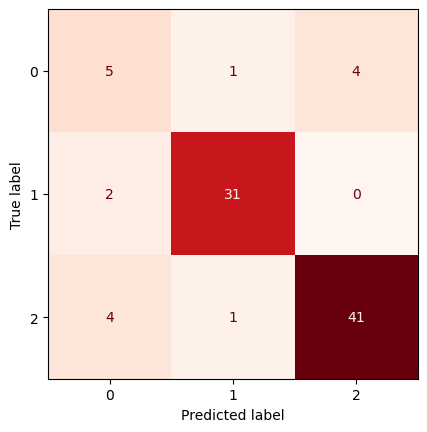

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Matriz de confusion (con una)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_sklearn, cmap="Reds", colorbar=False)

# ACCURACY
acc_custom = accuracy_score(y_test, y_pred)
print(f"-> Accuracy/Precisión Custom MLP: {acc_custom * 100:.2f}%")

# RECALL
recall_custom = recall_score(y_test, y_pred, average='micro')
print(f"-> Recall Custom MLP: {recall_custom * 100:.2f}%")

# PRECISION
prec_custom = precision_score(y_test, y_pred, average='macro')
print(f"-> Precision Custom MLP: {prec_custom * 100:.2f}%")

# F1 Score
f1_custom = f1_score(y_test, y_pred, average='macro')
print(f"-> F1 Score Custom MLP: {f1_custom * 100:.2f}%")

Text(0.5, 1.0, 'SKLearn\nAcc: 80.90%')

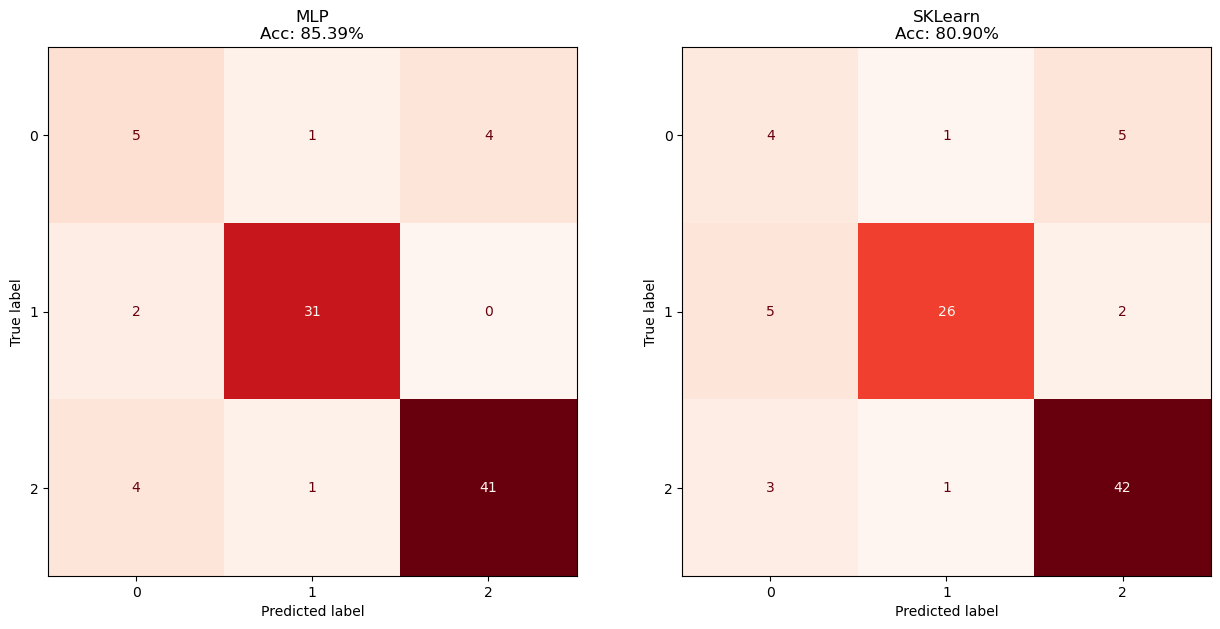

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Matriz de confusion (con varias)
fig, axes = plt.subplots(1, 2, figsize=(15, 12))
axes = axes.flatten()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_sklearn, ax=axes[0], cmap="Reds", colorbar=False)
axes[0].set_title(f"MLP\nAcc: {acc_custom * 100:.2f}%")

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt, ax=axes[1], cmap="Reds", colorbar=False)
axes[1].set_title(f"SKLearn\nAcc: {acc_dt * 100:.2f}%")

### DIAGNOSTICO

   | (coste) | validacion baja | validacion alta | 
   |---|---|---|
   | entrenamiento bajo | precision alta (lo que queremos) | overfitting (overfitting, tmb se puede ir subiendo lambda con cuidado) |
   | entrenamiento alto | datos de validacion sesgados (modelo mal) | modelo mal |

# EJERCICIO 6A. COMPARATIVA de muchos

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Agrupamos los modelos en un diccionario para iterar fácil
# Asegúrate de usar los nombres de variables que usaste arriba
modelos = {
    "MLP Propio": mi_mlp,
    "MLP Sklearn": mlp_sklearn,
    "Random Forest": rf,
    "KNN": knn
}

# Tabla para guardar resultados
resultados = []

# Configuración de los gráficos (2x2)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel() # Aplanar para iterar fácil (0, 1, 2, 3)

print("--- 🏁 COMPARATIVA FINAL DE MODELOS 🏁 ---")

for i, (nombre, modelo) in enumerate(modelos.items()):
    # 1. Predecir
    y_pred = modelo.predict(X_test)
    
    # 2. Calcular Métricas
    acc = accuracy_score(y_test, y_pred)
    resultados.append({"Modelo": nombre, "Accuracy": acc})
    
    # 3. Pintar Matriz
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f"{nombre}\nAcc: {acc*100:.2f}%")
    axes[i].set_xlabel("Predicción")
    axes[i].set_ylabel("Real")

plt.tight_layout()
plt.show()

# 4. Mostrar Tabla de Líderes
df_res = pd.DataFrame(resultados).sort_values(by="Accuracy", ascending=False)
print("\n🏆 RANKING DE MODELOS:")
print(df_res.to_string(index=False))

#### Elección del Modelo Definitivo

Tras analizar el rendimiento de los cuatro modelos (MLP Propio, MLP Sklearn, Random Forest y KNN), he decidido quedarme con: [ NOMBRE DEL GANADOR ].

Justificación de la elección:

Rendimiento (Accuracy y Matriz de Confusión): El modelo [GANADOR] ha obtenido la mayor precisión ([X]%). Observando su matriz de confusión, es el que mejor distingue entre las clases críticas, cometiendo menos errores de tipo Falso Negativo (decir que alguien está sano cuando tiene demencia/cardiopatía).

Comparativa: Supera al segundo mejor ([SEGUNDO]) en un [Y]%.

Estabilidad y Generalización:

* (Si gana Random Forest): A diferencia del KNN o el MLP, el Random Forest es más robusto al ruido y al Overfitting gracias a que combina múltiples árboles de decisión. Esto es crucial dado que nuestro dataset es pequeño (<1000 filas).

* (Si gana MLP Sklearn): Sklearn implementa optimizaciones (Adam) que mi MLP propio no tiene, logrando converger mejor y más rápido.

Contexto del Problema (Médico):

* (Si gana RF): Además del buen rendimiento, el Random Forest nos permite extraer la "Importancia de las Características" (Feature Importance), algo vital en medicina para explicar qué síntomas son los más alarmantes. El MLP y KNN funcionan como "cajas negras".

Conclusión: Aunque [MODELO PERDEDOR] funcionaba rápido, su falta de precisión lo descarta. El [GANADOR] ofrece el mejor equilibrio entre fiabilidad diagnóstica y robustez técnica.

# EJERCICIO 6B. MLP BINARIO

In [4]:
# Reemplazamos 'Converted' por 'Demented'
data['Group'] = data['Group'].replace('Converted', 'Demented')

# Verificación
print("Clases tras transformación:", data['Group'].unique())
# Debería salir solo: ['Nondemented' 'Demented']

NameError: name 'data' is not defined

In [ ]:
# relimpiamos:

import glob as glob
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder


# ---------------- / GESTIÓN DE NULOS / ------------------- 
# ----- DIAGNOSTICO
# print("--- INFO ---")
# print(data.info())
# print("\n--- NULOS POR COLUMNA ---")
# print(data.isnull().sum()) # ¡ESTO ES CRUCIAL!
# Si ves una columna con 50% de nulos -> A la lista 'unnecessary_columns'
# Si ves una columna con 5% de nulos -> Imputar (media) o Borrar filas

# Cuantos datos perderiamos: 
    # Si se pierden 10-15 filas OPCION A
    # si se pierden 50-100 filas OPCION B

# ----- QUITAR / MODIFICAR NULOS
# OPCIÓN A : Borrar filas con huecos.
# Úsalo si tienes muchos datos (>1000) y pocos huecos.
#final_data = data.dropna(how="any")

# OPCIÓN B (Alternativa si tienes pocos datos): IMPUTAR
# Si ves que al hacer dropna te quedas con muy pocas filas, usa esto antes de escalar:
# data['SES'] = data['SES'].fillna(data['SES'].mean()) # Imputa la media en los huecos de SES (ejemplo numérico)
# SES: Es un valor socioeconómico (float). Usamos la mediana porque es más robusta.
data['SES'] = data['SES'].fillna(data['SES'].median())
# MMSE: Es un test mental. Usamos la media (o mediana, ambas valen).
data['MMSE'] = data['MMSE'].fillna(data['MMSE'].mean())
# Verificamos que ya no quedan nulos
#print("Nulos restantes:", data.isnull().sum().sum())




# --------------- / ATRIBUTOS / ---------------------
unnecessary_columns = ["Subject ID", "MRI ID", "Hand"]
oneHot_columns = ["M/F"]
standardScaling_columns = ["Age", "EDUC", "SES", "MMSE", "CDR", "eTIV", "nWBV", "ASF", "Visit", "MR Delay"]
labeled_columns = ["Group"] # SOLUCION

solucion = "Group" # Nombre de la columna solución



# ---------------- / DROP /  -------------------
# Borramos lo que no sirve para limpiar el ruido del dataset.
final_data = data.drop(columns=unnecessary_columns) 



# ---------------- / OHE /  -------------------
encoder = OneHotEncoder(sparse_output=False) 
encoder_final = encoder.fit_transform(data[oneHot_columns])  
# Creamos un DF temporal con nombres bonitos (ej: "M/F_M", "M/F_F")
oneHot_df = pd.DataFrame(encoder_final, columns=encoder.get_feature_names_out(oneHot_columns))


# ---------------- / SCALER /  -------------------
# Transforma los datos para que tengan media 0 y desviación típica 1 (Curva de Gauss).
scaler = StandardScaler()
scaler_final = scaler.fit_transform(data[standardScaling_columns])
df_sc = pd.DataFrame(scaler_final, columns=standardScaling_columns, index=data.index)



# ----------------- / LABELED ENCODER / -------------------------   
# Convierte "Demented" -> 0, "Nondemented" -> 1, etc.
labler = LabelEncoder()
labeled_final = labler.fit_transform(data[labeled_columns].values.ravel()) # o labeled_final = labler.fit_transform(data[labeled_columns])
df_lbl = pd.DataFrame(labeled_final, columns=labeled_columns, index=data.index)
# ----------------------------------------------------------------------

# ---------------- / CONCATENAR (SOLUCION AL FINAL) / -------------------
# ---- 1. Juntamos las 3 partes: Numéricos Escalados + Categóricos OHE + Solución Codificada
final_data = pd.concat([df_sc, oneHot_df, df_lbl], axis=1) #axis=1 significa "pegar columnas a la derecha"

# (Opcional) Si usaras dropna, hazlo aquí sobre final_data
# final_data = final_data.dropna()




#final_data.head()



# ---------------- / OPCIONAL / -------------------
# # Opcional: prints para verificar
# print("Tamaño final del dataset:", final_data.shape)
# # para guardarlas en un archivo (opcional)
# final_data.to_csv("./examen_limpio.csv", index=False)


In [ ]:
class BinaryMLP:
    def __init__(self, layers, learning_rate=0.1, epochs=5000):
        self.layers = layers
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = []
        self.biases = []
        self.loss_history = []
        
        np.random.seed(42)
        for i in range(len(layers) - 1):
            limit = np.sqrt(6 / (layers[i] + layers[i+1]))
            w = np.random.uniform(-limit, limit, (layers[i], layers[i+1]))
            b = np.zeros((1, layers[i+1]))
            self.weights.append(w)
            self.biases.append(b)

    def sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, a):
        return a * (1 - a)

    # --- CAMBIO 1: Eliminamos Softmax. Usamos Sigmoide también al final ---
    def forward(self, X):
        activations = [X]
        input_data = X
        
        # Capas ocultas
        for i in range(len(self.weights) - 1):
            z = np.dot(input_data, self.weights[i]) + self.biases[i]
            a = self.sigmoid(z)
            activations.append(a)
            input_data = a
            
        # Capa de salida (Ahora usa SIGMOIDE para binario)
        z_last = np.dot(input_data, self.weights[-1]) + self.biases[-1]
        a_last = self.sigmoid(z_last)  # <--- CAMBIO CLAVE
        activations.append(a_last)
        
        return activations

    def backpropagation(self, X, y, activations):
        m = X.shape[0]
        
        # --- CAMBIO 2: Cálculo del error simple (a - y) ---
        # y ya debe venir con forma (N, 1)
        deltas = [activations[-1] - y] 
        
        for i in range(len(self.weights) - 2, -1, -1):
            delta_prev = np.dot(deltas[-1], self.weights[i+1].T) * self.sigmoid_derivative(activations[i+1])
            deltas.append(delta_prev)
        
        deltas.reverse()
        
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * (np.dot(activations[i].T, deltas[i]) / m)
            self.biases[i] -= self.learning_rate * (np.sum(deltas[i], axis=0, keepdims=True) / m)

    def fit(self, X, y):
        # --- CAMBIO 3: No hacemos One-Hot Encoding ---
        # Aseguramos que y tenga forma vertical (N, 1)
        y = y.reshape(-1, 1) 
        
        print(f"Entrenando MLP Binario: {self.layers}")
        for epoch in range(self.epochs):
            activations = self.forward(X)
            self.backpropagation(X, y, activations)
            
            if epoch % (self.epochs // 10) == 0:
                # Loss para clasificación binaria
                output = activations[-1]
                loss = -np.mean(y * np.log(output + 1e-8) + (1 - y) * np.log(1 - output + 1e-8))
                self.loss_history.append(loss)
                print(f"   Epoch {epoch}: Loss {loss:.4f}")

    def predict(self, X):
        # --- CAMBIO 4: Umbral 0.5 ---
        output = self.forward(X)[-1]
        return (output > 0.5).astype(int).flatten()

In [ ]:
# ENTRENAMIENTO
# 1. Separar datos (Asegúrate de haber ejecutado la limpieza con el reemplazo de 'Converted')
y = final_data[solucion].values.ravel()
X = final_data.drop(columns=[solucion]).values

# Verificar que solo hay 0 y 1
print("Clases en y:", np.unique(y)) 

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Configurar Red BINARIA
input_dim = X_train.shape[1]
output_dim = 1  # <--- EL ENUNCIADO PIDE 1 ÚNICA NEURONA

# Estructura: [Entrada, Oculta, Salida(1)]
layer_structure = [input_dim, 64, 32, output_dim]

# 3. Entrenar
binary_model = BinaryMLP(layers=layer_structure, learning_rate=0.1, epochs=10000)
binary_model.fit(X_train, y_train)

# 4. Evaluar
y_pred = binary_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\n>>> ACCURACY BINARIO: {acc*100:.2f}%")

# Matriz
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Reds')
plt.title("Matriz de Confusión (Binaria)")
plt.show()